# 多層パーセプトロンPython＆Chainerによる実装

## 2月の資料

### 多層パーセプトロンモデル

![title](img/mlp00.png)

### ユニットの入力と出力。

![title](img/mlp01.png)

## 多層パーセプトロンの数式

![title](img/mlp17.png)

$$y_k(\bf{x}, \bf{w}) = f \Biggl( \sum_{j=1}^M w_{kj}^{(2)} h \biggl( \sum_{i=1}^D w_{ji}^{(1)} x_i + w_{j0}^{(1)} \biggr) + w_{k0}^{(2)} \Biggr)$$

##### xo = 1とすると：

$$y_k(\bf{x}, \bf{w}) = f \Biggl( \sum_{j=0}^M w_{kj}^{(2)} h \biggl( \sum_{i=0}^D w_{ji}^{(1)} x_i \biggr) \Biggr)$$

##### 出力ユニット活性化関数はf()、隠れユニット活性化関数はh()で表しています。

## 重みの学習

### 全学習データの二乗誤差の和

![title](img/mlp6.png)
$$E_n = \frac{1}{2} \sum_{k=1}^K (y_k - t_k)^2$$

### 出力層の重み更新

Eを最小化するため、各wをどう求めるのは考えると、直接に二回微分で行うと、wがなくなるので使えない。
従って、一回微分で求める方法→最急降下法/確率的勾配降下法にした。

![title](img/mlp9.png)

##### ある重みwに対して、Eを最小化するため、wの微分値、つまり傾きが正の時はwが負の方向に動き、負の時はwが正の方向に動くようになった。また、傾きの絶対値が大きいときは大きく変化し、小さいときは小さく変化します。ただ、これだと更新量が大きすぎてうまく収束しないので、小さな正の定数を決めて、微分値に掛けることで更新量を調整する。

![title](img/mlp10.png)

##### 出力層i番目のユニットのj番目の重み、
$$w_{i,j}^{(L)}$$

##### wの更新式

$$
w_{ij}^{(L)} = w_{ij}^{(L)} - \eta\frac{\partial E_n}{\partial w_{ij}^{(L)}}
$$

##### E=f(y); y=f(u); u=f(w)、偏微分を求める時それぞれ偏微分するので以下の式に変更

$$
\frac{\partial E_n}{\partial w_{ij}^{(L)}} = \frac{\partial E_n}{\partial y_{i}^{(L)}}\frac{\partial y_{i}^{(L)}}{\partial u_{i}^{(L)}}\frac{\partial u_{i}^{(L)}}{\partial w_{ij}^{(L)}}
$$

##### さらに計算すると、以下の式になった(過程は省略)→http://hokuts.com/2016/05/29/bp1/ に参考してください。

$$
w_{ij}^{(L)} = w_{ij}^{(L)} - \eta((y_{i}^{(L)} - t_{i}){f'(u_{i}^{(L)})}{y_{j}^{(L-1)}})
$$

##### これは、出力層の重み更新式で、似たような計算で、隠れ層の重み更新式は以下のように:

![title](img/mlp12.png)

###### 計算後の式：

$$
w_{ij}^{(L-1)} = w_{ij}^{(L-1)} - \eta(\sum_{k} \frac{\partial E_n}{\partial y_{k}^{(L)}}\frac{\partial y_{k}^{(L)}}{\partial u_{k}^{(L)}}w_{k}^{(L)}{f'(u_{i}^{(L-1)})}{y_{j}^{(L-2)}})
$$

##### kは出力層のユニット

![title](img/mlp15.png)

##### 第L層の重み更新を先に計算すると、その計算結果の一部を第(L-1)層の重み更新の際に利用できた。プログラム上では一時変数に保持しておけば使える。それを使って第(L-1)層の重み更新の計算をし、さらにその計算結果の一部を第(L-2)層の重み更新に使い…ということができると、第1層の重みまですべてを更新することができる。

## Pythonによる実装

##### コード部分

##### 必要なライブラリを導入

<pre>#coding:utf-8
%matplotlib notebook
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
</pre>

##### 定数の定義

<pre>
# 訓練データ数
N = 50
# 学習率
ETA = 0.1　　#<b>どうの程度で重みwを調整するパラメータ</b>
# ループ回数
NUM_LOOP = 500  #<b>wを徐々に更新するので、一定の回数で回さないとうまく収束できない</b>
# 入力層のユニット数（バイアス含む）
NUM_INPUT = 2
# 隠れ層のユニット数（バイアス含む）
NUM_HIDDEN = 4
# 出力層のユニット数
NUM_OUTPUT = 1
</pre>

##### ユニットの出力関数

<pre>
def output(x, w1, w2):
    
    # <b>配列に変換して先頭にバイアスの1を挿入</b>
    x = np.insert(x, 0, 1)
    z = np.zeros(NUM_HIDDEN)
    y = np.zeros(NUM_OUTPUT)
    # 順伝播で出力を計算
    for j in range(NUM_HIDDEN):
        a = np.zeros(NUM_HIDDEN)
        a[j] = np.dot(w1[j, :], x)
        z[j] = np.tanh(a[j])     #<b>中間層の活性化関数はtan()</b>
    for k in range(NUM_OUTPUT):
        y[k] = np.dot(w2[k, :], z) #<b>出力層の活性化関数はそのまま線形関数の形</b>
    return y, z
</pre>

##### 訓練データ, 重み作成

<pre>
xlist = np.linspace(-5, 5, N).reshape(N, 1)
#tlist = xlist * xlist    # x^2
tlist = np.sin(xlist)     # sin(x) #<b>今回はsin()にした</b>
#tlist = np.abs(xlist)    # |x|

# <b>重みをランダムに初期化</b>
w1 = np.random.random((NUM_HIDDEN, NUM_INPUT))
w2 = np.random.random((NUM_OUTPUT, NUM_HIDDEN))
</pre>

##### 学習ループ

<pre>
ims = [] #グラッフ作成用
for loop in range(NUM_LOOP):
    for n in range(N):
        # 隠れ層と出力層の出力配列を確保
        z = np.zeros(NUM_HIDDEN)
        y = np.zeros(NUM_OUTPUT)

        # 誤差（delta）の配列を確保
        d1 = np.zeros(NUM_HIDDEN)
        d2 = np.zeros(NUM_OUTPUT)

        # 訓練データにバイアスの1を先頭に挿入
        x = np.array([xlist[n]])
        x = np.insert(x, 0, 1)

        # (1) 順伝播により隠れ層の出力を計算
        for j in range(NUM_HIDDEN):
            a = np.zeros(NUM_HIDDEN)
            a[j] = np.dot(w1[j, :], x)
            z[j] = np.tanh(a[j])

        # (1) 順伝播により出力層の出力を計算
        for k in range(NUM_OUTPUT):
            y[k] = np.dot(w2[k, :], z)

        #  <b>出力層の誤差を評価</b>
        for k in range(NUM_OUTPUT):
            d2[k] = y[k] - tlist[n, k] #n,kは行と列に対応

　　　　　#　<b>出力層の重みを更新</b>
        for k in range(NUM_OUTPUT):
            for j in range(NUM_HIDDEN):
                w2[k, j] -= ETA * d2[k] * z[j]
</pre>

$$
w_{ij}^{(L)} = w_{ij}^{(L)} - \eta((y_{i}^{(L)} - t_{i}){f'(u_{i}^{(L)})}{y_{j}^{(L-1)}})
$$

<pre>
        #  <b>出力層の誤差を逆伝播させ、隠れ層の誤差を計算</b>
        for j in range(NUM_HIDDEN):
            temp = np.dot(w2[:, j], d2)
            d1[j] = (1 - z[j] * z[j]) * temp

        #  <b>隠れ層の重みを更新</b>
        for j in range(NUM_HIDDEN):
            for i in range(NUM_INPUT):
                w1[j, i] -= ETA * d1[j] * x[i]
</pre>

$$
w_{ij}^{(L-1)} = w_{ij}^{(L-1)} - \eta(\sum_{k} \frac{\partial E_n}{\partial y_{k}^{(L)}}\frac{\partial y_{k}^{(L)}}{\partial u_{k}^{(L)}}w_{k}^{(L)}{f'(u_{i}^{(L-1)})}{y_{j}^{(L-2)}})
$$

<pre>
    # 訓練データの入力に対する予測値を出力
    ylist = np.zeros((N, NUM_OUTPUT))
    zlist = np.zeros((N, NUM_HIDDEN))
    for n in range(N):
        ylist[n], zlist[n] = output(xlist[n], w1, w2)

    # 訓練データを青丸で表示
    # plot()には縦ベクトルを渡してもOK
    im = plt.plot(xlist, tlist, 'bo')

    # 訓練データの各xに対するニューラルネットの出力を赤線で表示
    im += plt.plot(xlist, ylist, 'r-')

    # 各重みの出力を点線で表示
    for i in range(NUM_HIDDEN):
        im += plt.plot(xlist, zlist[:,i], 'k--')
    
    ims.append(im)
</pre>

##### 動画を表示

<pre>
fig = plt.figure()
ani = animation.ArtistAnimation(fig, ims)
plt.show()
</pre>

##### 実行する

<IPython.core.display.Javascript object>


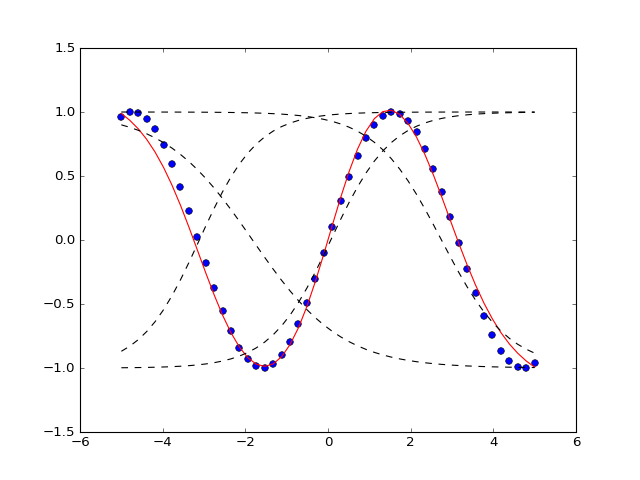

<IPython.core.display.Javascript object>


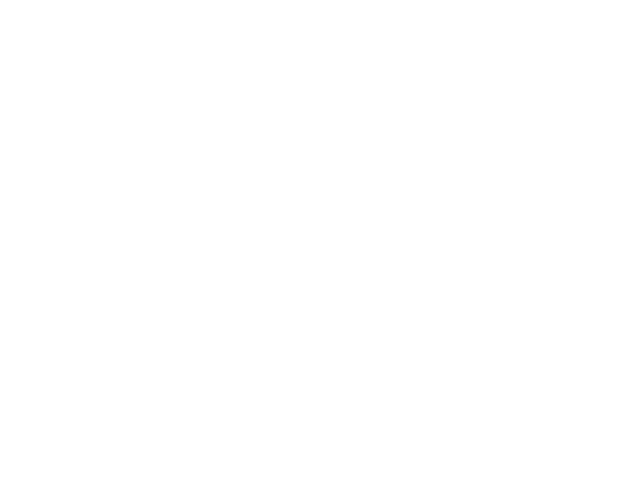

In [1]:
#coding:utf-8
%matplotlib notebook
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt

# 訓練データ数
N = 50
# 学習率
ETA = 0.1
# ループ回数
NUM_LOOP = 500
# 入力層のユニット数（バイアス含む）
NUM_INPUT = 2
# 隠れ層のユニット数（バイアス含む）
NUM_HIDDEN = 4
# 出力層のユニット数
NUM_OUTPUT = 1

def output(x, w1, w2):
    """xを入力したときのニューラルネットワークの出力を計算
    隠れユニットの出力も一緒に返す"""
    # 配列に変換して先頭にバイアスの1を挿入
    x = np.insert(x, 0, 1)
    z = np.zeros(NUM_HIDDEN)
    y = np.zeros(NUM_OUTPUT)
    # 順伝播で出力を計算
    for j in range(NUM_HIDDEN):
        a = np.zeros(NUM_HIDDEN)
        a[j] = np.dot(w1[j, :], x)
        z[j] = np.tanh(a[j])
    for k in range(NUM_OUTPUT):
        y[k] = np.dot(w2[k, :], z)
    return y, z

# 訓練データ作成
xlist = np.linspace(-5, 5, N).reshape(N, 1)
#tlist = xlist * xlist    # x^2
tlist = np.sin(xlist)     # sin(x)
#tlist = np.abs(xlist)    # |x|
#tlist = heviside(xlist)  # H(x)

# 重みをランダムに初期化
w1 = np.random.random((NUM_HIDDEN, NUM_INPUT))
w2 = np.random.random((NUM_OUTPUT, NUM_HIDDEN))

#print "学習前の二乗誤差:", sum_of_squares_error(xlist, tlist, w1, w2)

ims = []

for loop in range(NUM_LOOP):
    # 訓練データすべてを使って重みを訓練する
    for n in range(N):
        # 隠れ層と出力層の出力配列を確保
        z = np.zeros(NUM_HIDDEN)
        y = np.zeros(NUM_OUTPUT)

        # 誤差（delta）の配列を確保
        d1 = np.zeros(NUM_HIDDEN)
        d2 = np.zeros(NUM_OUTPUT)

        # 訓練データにバイアスの1を先頭に挿入
        x = np.array([xlist[n]])
        x = np.insert(x, 0, 1)

        # (1) 順伝播により隠れ層の出力を計算
        for j in range(NUM_HIDDEN):
            # 入力層にはバイアスの1が先頭に入るので注意
            a = np.zeros(NUM_HIDDEN)
            a[j] = np.dot(w1[j, :], x)
            z[j] = np.tanh(a[j])

        # (1) 順伝播により出力層の出力を計算
        for k in range(NUM_OUTPUT):
            y[k] = np.dot(w2[k, :], z)

        # (2) 出力層の誤差を評価
        for k in range(NUM_OUTPUT):
            d2[k] = y[k] - tlist[n, k]

        # (3) 出力層の誤差を逆伝播させ、隠れ層の誤差を計算
        for j in range(NUM_HIDDEN):
            temp = np.dot(w2[:, j], d2)
            d1[j] = (1 - z[j] * z[j]) * temp

        # (4) + (5) 第1層の重みを更新
        for j in range(NUM_HIDDEN):
            for i in range(NUM_INPUT):
                w1[j, i] -= ETA * d1[j] * x[i]
            
        # (4) + (5) 第2層の重みを更新
        for k in range(NUM_OUTPUT):
            for j in range(NUM_HIDDEN):
                w2[k, j] -= ETA * d2[k] * z[j]

    # 訓練データの入力に対する予測値を出力
    ylist = np.zeros((N, NUM_OUTPUT))
    zlist = np.zeros((N, NUM_HIDDEN))
    for n in range(N):
        ylist[n], zlist[n] = output(xlist[n], w1, w2)

    # 訓練データを青丸で表示
    # plot()には縦ベクトルを渡してもOK
    im = plt.plot(xlist, tlist, 'bo')

    # 訓練データの各xに対するニューラルネットの出力を赤線で表示
    im += plt.plot(xlist, ylist, 'r-')

    # 各重みの出力を点線で表示
    for i in range(NUM_HIDDEN):
        im += plt.plot(xlist, zlist[:,i], 'k--')
    
    ims.append(im)

fig = plt.figure()
ani = animation.ArtistAnimation(fig, ims)
plt.show()

## Chainerによる実装

### 必要なものをimport

<pre>
import chainer
import chainer.functions as F
import chainer.links as L
import numpy as np
from chainer import Variable
from chainer import optimizers
from matplotlib import pyplot as plt
%matplotlib inline
</pre>

### データを準備

<pre>
N = 50
NUM_LOOP = 1000
x_data = np.linspace(-1, 1, N, dtype=np.float32).reshape(N,1)
t_data = x_data * x_data    # x^2
#    tlist = np.sin(xlist)    # sin(x)
#    tlist = np.abs(xlist)    # |x|
#    tlist = heviside(xlist)  # H(x)
</pre>

### モデルを構築

<pre>
class MLP(chainer.Chain):
    def __init__(self, n_in, n_units, n_out):
        super(MLP, self).__init__(
            l1=L.Linear(n_in,n_units),
            l2=L.Linear(n_units,n_out)
        )
        
    def __call__(self, x):
        h1 = F.tanh(self.l1(x))
        h2 = self.l2(h1)
        #h1 = F.leaky_relu(self.l1(x))
        #h2 = F.leaky_relu(self.l2(h1))
        return h2

class SUMError(chainer.Chain):
    def __init__(self, predictor):
        super(SUMError, self).__init__(predictor=predictor)
    
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.mean_squared_error(y, t) //Mean squared error (a.k.a. Euclidean loss) function
        return self.loss
</pre>

### Optimizerを設定

<pre>
model = SUMError(MLP(1, 4, 1))
optimizer = optimizers.SGD()
optimizer.setup(model)
</pre>

他のパラメータとその意味は、[ここ](http://ttlg.hateblo.jp/entry/2016/02/11/181322) で参考できる

### Trainを行う

<pre>
losses = []
for loop in range(NUM_LOOP):
    x = Variable(x_data)
    t = Variable(t_data.astype(np.float32))
    model.zerograds()
    loss = model(x, t)
    loss.backward()
    optimizer.update()
    losses.append(loss.data)
</pre>

### 実行する

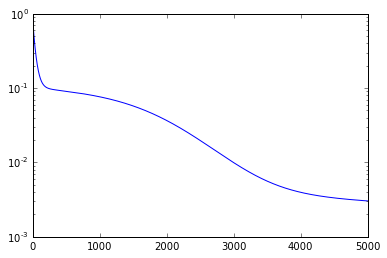

In [1]:
import chainer
import chainer.functions as F
import chainer.links as L
import numpy as np
from chainer import Variable
from chainer import optimizers
from matplotlib import pyplot as plt
%matplotlib inline

N = 50
NUM_LOOP = 5000
x_data = np.linspace(-1, 1, N, dtype=np.float32).reshape(N,1)
t_data = x_data * x_data        # x^2
#    t_data = np.sin(x_data)    # sin(x)
#    t_data = np.abs(x_data)    # |x|

class MLP(chainer.Chain):
    def __init__(self, n_in, n_units, n_out):
        super(MLP, self).__init__(
            l1=L.Linear(n_in,n_units),
            l2=L.Linear(n_units,n_out)
        )
        
    def __call__(self, x):
        h1 = F.tanh(self.l1(x))
        h2 = self.l2(h1)
        #h1 = F.leaky_relu(self.l1(x))
        #h2 = F.leaky_relu(self.l2(h1))
        return h2

class SUMError(chainer.Chain):
    def __init__(self, predictor):
        super(SUMError, self).__init__(predictor=predictor)
    
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.mean_squared_error(y, t)
        return self.loss
    
model = SUMError(MLP(1, 4, 1))
optimizer = optimizers.SGD()
optimizer.setup(model)
losses = []
for loop in range(NUM_LOOP):
    x = Variable(x_data)
    t = Variable(t_data.astype(np.float32))
    model.zerograds()
    loss = model(x, t)
    loss.backward()
    optimizer.update()
    losses.append(loss.data)
plt.plot(losses)
plt.yscale('log')
